In [218]:
# import ccxt
# import pprint

# # with open("../binance.key") as f:
# #     lines = f.readlines()
# #     api_key = lines[0].strip()
# #     api_secret = lines[1].strip()
   

# api_key = "3o8od3V5ePVCnZ19u34KydThmSgbD2ekCV4yD9ZclRogzMvMl4RPFlfLW8fVpzFX"
# api_secret = "ZRzqHcLKS7Lnemy5cwM2Cck0HRnguN59jQvzAqrrXAoZvGwS9AKZk1dHbvZqBXyA"

# exchange = ccxt.binance(config={
#     'apiKey': api_key,
#     'secret': api_secret,
#     'enableRateLimit': True,
#     'options': {
#         'defaultType': 'future'       # 선물 거래
#     }
# })
# print(exchange)

# markets = exchange.load_markets()
# tickers = exchange.fetch_tickers()

# # :usdt 종목 선별
# symbols = tickers.keys()
# usdt_symbols = [x for x in symbols if x.endswith("USDT")]

# import pandas as pd

# timeframe = '1d'

# # 각 코인의 가격 데이터를 저장할 딕셔너리
# prices_data = {}

# # 각 심볼에 대해 OHLCV 데이터를 가져와서 딕셔너리에 저장
# for symbol in usdt_symbols:
#     ohlcv = exchange.fetch_ohlcv(symbol=symbol, timeframe=timeframe, limit=2000)
#     df = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
#     df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')  # timestamp를 datetime으로 변환
    
#     if len(df) > 1400:
#         print(symbol)
#         prices_data[symbol] = df

In [219]:
len(prices_data)

16

In [220]:

data = prices_data['BCH/USDT:USDT'][:-200]

### 모델 학습

In [221]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 윈도우 사이즈
window_size = 30


# 윈도우에 따른 데이터 정규화 함수 정의
def window_scaler(window_data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(window_data)

columns = ['open', 'high', 'low', 'close', 'volume']
scaled_data = []

# 데이터 합치기
# for key, value in prices_data.items():
#     data = value
#     for start in range(len(data) - window_size):
#         end = start + window_size
#         window_data = data[columns][start:end]
#         scaled_window_data = window_scaler(window_data)
#         scaled_data.append(scaled_window_data)

# 개별
for start in range(len(data) - window_size):
    end = start + window_size
    window_data = data[columns][start:end]
    scaled_window_data = window_scaler(window_data)
    scaled_data.append(scaled_window_data)

        
# 리스트를 numpy 배열로 변환
scaled_data = np.array(scaled_data)

# 예측할 조건 설정
forecast_days = 7  # 예측하려는 일수

# 특성(Features)과 레이블(Labels)을 위한 빈 리스트 생성
features = []
labels = []

# 예측 조건에 따른 레이블 생성
# for key, value in prices_data.items():
#     data = value
#     for i in range(len(data) - window_size - forecast_days):
#         print(i)
#         features.append(scaled_data[i])
#         close_today = data['close'][i + window_size - 1]
#         close_future = data['close'][i + window_size + forecast_days - 1]
#         labels.append(int(close_future > close_today))

        
for i in range(len(scaled_data) - forecast_days):
    features.append(scaled_data[i])
    close_today = data['close'][i + window_size - 1]
    close_future = data['close'][i + window_size + forecast_days - 1]
    labels.append(int(close_future > close_today))

# numpy 배열로 변환
features = np.array(features)
labels = np.array(labels)

from sklearn.model_selection import train_test_split

# 데이터를 학습 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 모델 생성
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 데이터 차원 변경:
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples, nx*ny))

# 모델 학습
model.fit(X_train_2d, y_train)

#테스트 데이터
nsamples, nx, ny = X_test.shape
X_test_2d = X_test.reshape((nsamples, nx*ny))


In [222]:
# 성능 평가
predictions = model.predict(X_test_2d)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


              precision    recall  f1-score   support

           0       0.66      0.61      0.63       190
           1       0.61      0.65      0.63       175

    accuracy                           0.63       365
   macro avg       0.63      0.63      0.63       365
weighted avg       0.63      0.63      0.63       365

[[116  74]
 [ 61 114]]


In [223]:
scaled_data.shape

(1222, 30, 5)

## 백테스트


In [224]:
# # i번째 데이터를 가져오고자 하는 경우 (예: i = 1)
# i = 1
# keys = list(prices_data.keys())  # 딕셔너리의 키를 리스트로 변환
# values = list(prices_data.values())  # 딕셔너리의 값들을 리스트로 변환

# if 0 <= i < len(keys):
#     key_i = keys[i]
#     value_i = values[i]
#     print(f'{i}번째 데이터 - Key: {key_i}, Value: {value_i}')
# else:
#     print(f'{i}번째 데이터를 찾을 수 없습니다.')

# data = value_i

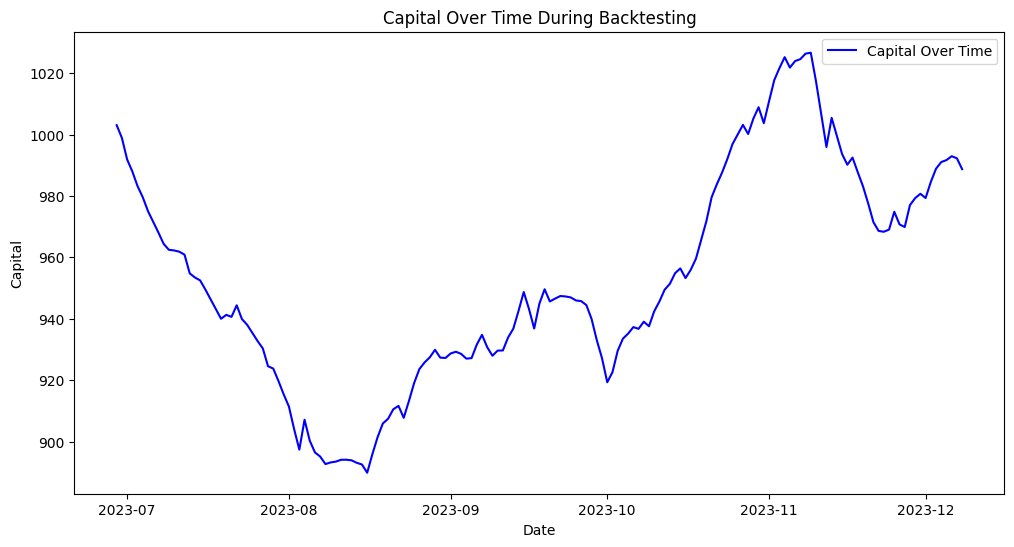

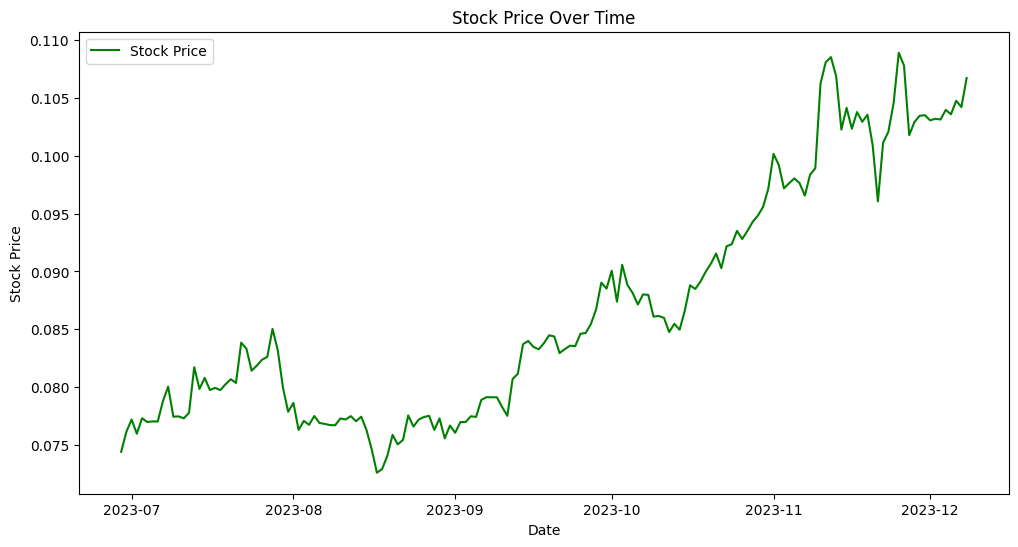

In [225]:
# 과거 주식 데이터 로드

data = prices_data['TRX/USDT:USDT'][-200:]

data.reset_index(drop=True, inplace=True)
historical_data = data
# 데이터 정규화 및 특성 생성
scaled_historical_data = []
for start in range(len(historical_data) - window_size):
    end = start + window_size
    window_data = historical_data[columns][start:end]
    scaled_window_data = window_scaler(window_data)
    scaled_historical_data.append(scaled_window_data)

scaled_historical_data = np.array(scaled_historical_data)

# 특성 생성
historical_features = []
for i in range(len(scaled_historical_data) - forecast_days):
    historical_features.append(scaled_historical_data[i])

historical_features = np.array(historical_features)

# 백테스팅을 위한 데이터 차원 변경
nsamples, nx, ny = historical_features.shape
historical_features_2d = historical_features.reshape((nsamples, nx*ny))

# 모델로 과거 데이터 예측
historical_predictions = model.predict(historical_features_2d)

import matplotlib.pyplot as plt

dates = historical_data['datetime'][window_size + forecast_days - 1:len(historical_predictions) + window_size + forecast_days - 1]

# 백테스팅 시뮬레이션
initial_capital = 1000.0
capital = initial_capital
capital_history = []  # 초기 자본을 리스트에 추가
profit_history = []
bet_size = 100

# historical_predictions의 길이에 맞게 반복
for i in range(len(historical_predictions)):
    # 예측에 해당하는 실제 인덱스 계산
    actual_index = i + window_size + forecast_days - 1
    if historical_predictions[i] == 1:
        # 상승 예측: 매수 포지션
        if capital >= bet_size:
            profit = bet_size * (historical_data['close'][actual_index] / historical_data['close'][actual_index - forecast_days] - 1)
            profit_history.append(profit)
            capital += profit  # 수익 추가
    elif historical_predictions[i] == 0:
        # 하락 예측: 매도 포지션
        if capital >= bet_size:
            profit = bet_size * (1 - historical_data['close'][actual_index] / historical_data['close'][actual_index - forecast_days])
            profit_history.append(profit)
            capital += profit  # 수익 추가

    capital_history.append(capital)

# dates 리스트 생성
dates = historical_data['datetime'][window_size + forecast_days - 1: window_size + forecast_days - 1 + len(historical_predictions)]

# 자본 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(dates, capital_history, label='Capital Over Time', color='blue')
plt.title('Capital Over Time During Backtesting')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()
plt.show()

# 주가 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(dates, historical_data['close'][window_size + forecast_days - 1:window_size + forecast_days - 1 + len(historical_predictions)], label='Stock Price', color='green')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



In [226]:
# 예측 성공 여부 계산
prediction_success = [
    1 if (historical_predictions[i] == 1 and historical_data['close'][window_size + forecast_days - 1 + i] > historical_data['close'][window_size + forecast_days - 1 + i - forecast_days]) or
       (historical_predictions[i] == 0 and historical_data['close'][window_size + forecast_days - 1 + i] < historical_data['close'][window_size + forecast_days - 1 + i - forecast_days])
    else 0
    for i in range(len(historical_predictions))
]

# DataFrame 생성
backtesting_df = pd.DataFrame({
    'Date': dates,
    'Open': historical_data['open'][window_size + forecast_days - 1:window_size + forecast_days - 1 + len(historical_predictions)],
    'High': historical_data['high'][window_size + forecast_days - 1:window_size + forecast_days - 1 + len(historical_predictions)],
    'Low': historical_data['low'][window_size + forecast_days - 1:window_size + forecast_days - 1 + len(historical_predictions)],
    'Close': historical_data['close'][window_size + forecast_days - 1:window_size + forecast_days - 1 + len(historical_predictions)],
    'Profit': profit_history,
    'Capital': capital_history,  # 첫 번째 초기 자본 제외
    'Prediction': historical_predictions,
    'Prediction Success': prediction_success
})

# DataFrame 출력
print(backtesting_df)


          Date     Open     High      Low    Close    Profit      Capital  \
36  2023-06-29  0.07370  0.07477  0.07333  0.07441  3.075218  1003.075218   
37  2023-06-30  0.07440  0.07683  0.07386  0.07614 -4.158687   998.916531   
38  2023-07-01  0.07613  0.07767  0.07568  0.07720 -6.999307   991.917224   
39  2023-07-02  0.07720  0.07738  0.07519  0.07597 -3.926129   987.991096   
40  2023-07-03  0.07597  0.07785  0.07572  0.07731 -4.784494   983.206601   
..         ...      ...      ...      ...      ...       ...          ...   
194 2023-12-04  0.10313  0.10611  0.10201  0.10396  2.151911   991.047731   
195 2023-12-05  0.10396  0.10433  0.10246  0.10358  0.651054   991.698786   
196 2023-12-06  0.10359  0.10623  0.10212  0.10475  1.256646   992.955431   
197 2023-12-07  0.10475  0.10570  0.10293  0.10420 -0.676329   992.279103   
198 2023-12-08  0.10420  0.10734  0.10416  0.10671 -3.541626   988.737477   

     Prediction  Prediction Success  
36            1                   1  

In [227]:
import pandas as pd

# DataFrame 생성 (예시 데이터)

# 'column_name' 열에서 1의 개수 세기
count_ones = (backtesting_df['Prediction Success'] == 1).sum()

# 'column_name' 열에서 0의 개수 세기
count_zeros = (backtesting_df['Prediction Success'] == 0).sum()

print(f"1의 개수: {count_ones}")
print(f"0의 개수: {count_zeros}")
print(count_ones/(count_zeros+count_ones))

1의 개수: 80
0의 개수: 83
0.49079754601226994


In [228]:
backtesting_df.to_excel("backtest.xlsx")